# Global preparations

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import logging
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from tqdm.notebook import tqdm

sys.path.insert(0, os.path.expanduser('~/spiky'))
device = 'cuda:5'
summation_dtype = torch.float32
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = True
logger = logging.getLogger('stdout_logger')
logger.setLevel(logging.INFO)
if not logger.hasHandlers():
    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setFormatter(logging.Formatter(fmt='%(asctime)s|%(levelname)s|%(message)s'))
    logger.addHandler(stdout_handler)

# MNIST preparation

Let's read the MNIST dataset and represent it in sparse form

In [2]:
mnist_dataset_dir = 'mnist'

import torchvision.transforms as T

# transform = T.Normalize((0.1307,), (0.3081,))

mnist_train_dataset = torchvision.datasets.MNIST(
    mnist_dataset_dir, train=True, download=True
)
mnist_test_dataset = torchvision.datasets.MNIST(
    mnist_dataset_dir, train=False, download=True
)
mnist_train_data_device = mnist_train_dataset.data.to(device=device).to(dtype=torch.float32) / 255
mnist_test_data_device = mnist_test_dataset.data.to(device=device).to(dtype=torch.float32) / 255
mnist_train_targets_device = mnist_train_dataset.targets.to(device=device)
mnist_test_targets_device = mnist_test_dataset.targets.to(device=device)

mnist_train_dataset = TensorDataset(
    mnist_train_data_device, mnist_train_targets_device
)
mnist_test_dataset = TensorDataset(
    mnist_test_data_device, mnist_test_targets_device
)

# mnist_train_dataset = TensorDataset(
#     transform(mnist_train_data_device), mnist_train_targets_device
# )
# mnist_test_dataset = TensorDataset(
#     transform(mnist_test_data_device), mnist_test_targets_device
# )

In [3]:
mnist_test_loader = torch.utils.data.DataLoader(
    mnist_train_dataset,
    batch_size=1, shuffle=True
)

example_data, example_targets = next(iter(mnist_test_loader))
to_pil_image(example_data[0])

In [4]:
patch_h = patch_w = 28
input_shape = (patch_h, patch_w)
clustering_dim = 44

In [5]:
example_data

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

# Baseline autoencoder

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ============================================================
# Conv VAE
# ============================================================
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()

        # Encoder: 1×28×28 → 256
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 14×14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 7×7
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu     = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder: latent → 1×28×28
        self.fc_dec = nn.Linear(latent_dim, 64 * 7 * 7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 14×14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1)    # 28×28 (logits)
        )

    def encode(self, x):
        h = self.enc(x)
        return self.fc_mu(h), self.fc_logvar(h).clamp(-10, 10)

    def reparameterize(self, mu, logvar):
        return mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)

    def decode(self, z):
        h = self.fc_dec(z).view(-1, 64, 7, 7)
        return self.dec(h)

    def forward(self, x):
        x = x.unsqueeze(1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        logits = self.decode(z)
        return logits, mu, logvar


# ============================================================
# Loss
# ============================================================
def vae_loss(x, logits, mu, logvar, epoch):
    recon = F.binary_cross_entropy_with_logits(
        logits, x.unsqueeze(1), reduction="sum"
    ) / x.size(0)

    kl = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    ) / x.size(0)
    
    beta = min(1.0, epoch / 10.0)
    loss = recon + beta * kl

    return recon + beta * kl


# ============================================================
# Train / Eval
# ============================================================
def train_epoch(model, loader, optimizer, device, epoch):
    model.train()
    total = 0.0
    for x, _ in loader:
        x = x.to(device)  # [B,1,28,28], in [0,1]
        optimizer.zero_grad()
        logits, mu, logvar = model(x)
        loss = vae_loss(x, logits, mu, logvar, epoch)
        loss.backward()
        optimizer.step()
        total += loss.item() * x.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader, device, epoch):
    model.eval()
    total = 0.0
    for x, _ in loader:
        x = x.to(device)
        logits, mu, logvar = model(x)
        total += vae_loss(x, logits, mu, logvar, epoch).item() * x.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def eval_mse(model, loader, device):
    model.eval()
    total = 0.0
    n = 0

    for x, _ in loader:
        x = x.to(device)           # [B,28,28] or [B,1,28,28]

        logits, _, _ = model(x)
        recon = torch.sigmoid(logits)

        total += F.mse_loss(recon, x.unsqueeze(1), reduction="sum").item()
        n += x.numel()

    return total / n   # per-pixel MSE

In [8]:
# -------------------------
# Usage
# -------------------------
baseline_net = ConvVAE(latent_dim=64).to(device)
optimizer = torch.optim.Adam(baseline_net.parameters(), lr=1e-3)

In [8]:
total = sum(p.numel() for p in baseline_net.parameters())
trainable = sum(p.numel() for p in baseline_net.parameters() if p.requires_grad)

print("total:", total)
print("trainable:", trainable)
print("frozen:", total - trainable)

total: 672065
trainable: 672065
frozen: 0


In [9]:
for epoch in range(64):
    train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=128, shuffle=True)
    tr = train_epoch(baseline_net, train_loader, optimizer, device, epoch)
    test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=256, shuffle=True)
    te = eval_epoch(baseline_net, test_loader, device, epoch)
    te_mse = eval_mse(baseline_net, test_loader, device)
    print(epoch, tr, te, te_mse)

0 99.49101196289062 60.41294827880859 0.00529094099706533
1 74.18949994710286 70.31746845703125 0.004936310324376943


KeyboardInterrupt: 

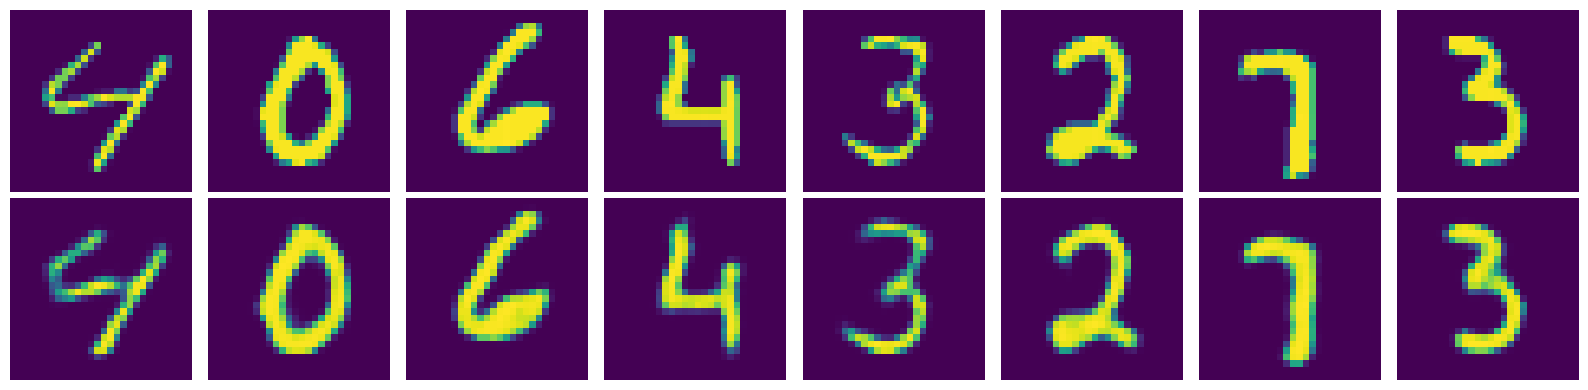

In [10]:
import torch
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import random

@torch.no_grad()
def show_reconstructions(model, dataset, device, n=8):
    model.eval()

    idx = random.sample(range(len(dataset)), n)
    x = torch.stack([dataset[i][0] for i in idx]).to(device)  # [B,28,28]

    logits, _, _ = model(x)
    recon = torch.sigmoid(logits)

    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))
    for i in range(n):
        axes[0, i].imshow(to_pil_image(x[i].cpu()))
        axes[0, i].axis("off")
        axes[1, i].imshow(to_pil_image(recon[i].cpu()))
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Reconstruction")
    plt.tight_layout()
    plt.show()

show_reconstructions(baseline_net, mnist_test_dataset, device, n=8)

# ANDN autoencoder

In [503]:
from spiky.util.synapse_growth import SynapseGrowthEngine
from spiky.util.chunk_of_connections import ChunkOfConnections
from spiky.andn.ANDNLayer import ANDNLayer, SynapseMeta
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2DInverseANDNLayer(ANDNLayer):
    def __init__(
        self, straight_andn_layer, output_shape,
        synapse_meta=SynapseMeta(),
        backprop_hebb_ratio_on_torch_backward=1.0,
        anti_hebb_coeff=0.0,
        summation_dtype=torch.float32,
        _int_rescaler=0.001,
        _forward_group_size: int = 64,
        _backward_group_size: int = 64,
        random_seed=None,
        device=None
    ):
        input_shape = straight_andn_layer.output_shape()
        n_inputs = input_shape[0] * input_shape[1]
        n_outputs = output_shape[0] * output_shape[1]
        n_synapses = straight_andn_layer._count_synapses(straight_andn_layer.get_input_neuron_ids(), True)

        super().__init__(
            n_inputs=n_inputs,
            n_outputs=n_outputs,
            n_detectors=0,
            max_inputs_per_detector=0,
            synapse_metas=[synapse_meta],
            backprop_hebb_ratio_on_torch_backward=backprop_hebb_ratio_on_torch_backward,
            anti_hebb_coeff=anti_hebb_coeff,
            summation_dtype=summation_dtype,
            _int_rescaler=_int_rescaler,
            _initial_synapse_capacity=n_synapses,
            _forward_group_size=_forward_group_size,
            _backward_group_size=_backward_group_size
        )

        if device is not None:
            self.to(device=device)
        else:
            device = torch.device("cpu")

        
        synapses_export = {
            'source_ids': torch.zeros([n_synapses], dtype=torch.int32, device=device),
            'weights': torch.zeros([n_synapses], dtype=torch.float32, device=device),
            'target_ids': torch.zeros([n_synapses], dtype=torch.int32, device=device)
        }

        straight_andn_layer._export_synapses(
            straight_andn_layer.get_input_neuron_ids(),
            synapses_export['source_ids'],
            synapses_export['weights'],
            synapses_export['target_ids'],
            forward_or_backward=True
        )
        
        explicit_triples = torch.cat(
            [
                torch.zeros([n_synapses, 1], dtype=torch.int32, device=device),
                synapses_export['target_ids'].unsqueeze(1) - n_outputs + 1,
                synapses_export['source_ids'].unsqueeze(1) + n_inputs + 1
            ],
            dim=-1
        )

        growth_engine = SynapseGrowthEngine(device=device, synapse_group_size=64, max_groups_in_buffer=2**10)
        growth_engine._max_neuron_id = explicit_triples[:, 1:].max().item()
        
        chunk_of_connections=growth_engine._grow_explicit(explicit_triples, random_seed, True)
        chunk_of_connections._connections = chunk_of_connections._connections.to(device=device)
        
        self.add_connections(
            chunk_of_connections=chunk_of_connections,
            ids_shift=-1,
            random_seed=random_seed
        )

        self.compile_andn()
        self._output_shape = output_shape

    def output_shape(self):
        return self._output_shape

    def export_weights(self):
        n_synapses = self.n_synapses()
        source_ids = torch.zeros([n_synapses], dtype=torch.int32, device=self.device)
        target_ids = torch.zeros([n_synapses], dtype=torch.int32, device=self.device)
        weights = torch.zeros([n_synapses], dtype=torch.float32, device=self.device)

        self._export_synapses(
            self.get_output_neuron_ids(),
            source_ids,
            weights,
            target_ids,
            forward_or_backward=False
        )

        order = torch.argsort(source_ids, stable=True, descending=False)
        order = order[torch.argsort(target_ids[order], stable=True, descending=False)]

        return weights[order].reshape(self._output_shape + self._receptive_field_shape)

In [520]:
from spiky.andn.ANDNLayer import Conv2DANDNLayer, Grid2DInhibitionLayer, SynapseMeta

synapse_meta_s = SynapseMeta(
    min_weight=0.0,
    max_weight=4.0,
    initial_weight=4.0,
    initial_noise_level=-4.0
)

synapse_meta_i = SynapseMeta(
    min_weight=-1.0,
    max_weight=1.0,
    initial_weight=1.0,
    initial_noise_level=-2.0
)

cl_dim_1 = 6
cl_dim_2 = 8
p_dim = 4

andn_shapes = [
    {
        'inhibition': (cl_dim_1, cl_dim_1),
        'straight': {
            'receptive_field': (p_dim, p_dim),
            'receptive_field_stride': (1, 1),
            'output_kernel': (cl_dim_1, cl_dim_1)
        }
    },
    {
        'inhibition': (cl_dim_2, cl_dim_2),
        'straight': {
            'receptive_field': (p_dim * cl_dim_1, p_dim * cl_dim_1),
            'receptive_field_stride': (cl_dim_1 * 2, cl_dim_1 * 2),
            'output_kernel': (cl_dim_2, cl_dim_2)
        }
    },
    {
        'inhibition': (cl_dim_2, cl_dim_2),
        'straight': {
            'receptive_field': (p_dim * cl_dim_2, p_dim * cl_dim_2),
            'receptive_field_stride': (cl_dim_2 * 2, cl_dim_2 * 2),
            'output_kernel': (cl_dim_2 * 2, cl_dim_2 * 2)
        }
    },
#     {
#         'inhibition': (cl_dim, cl_dim),
#         'straight': {
#             'receptive_field': (p_dim * cl_dim * 3, p_dim * cl_dim * 3),
#             'receptive_field_stride': (cl_dim * 3, cl_dim * 3),
#             'output_kernel': (cl_dim * 3, cl_dim * 3)
#         }
#     },
]

class ANDNAutoencoder(nn.Module):
    def __init__(self, input_shape, device):
        super().__init__()
        self.straight_layers = []
        self.inhibition_layers = []
        self.inverse_layers = []
        biases = []
        
        
        prev_output_shape = input_shape
        
        for i, sh in enumerate(andn_shapes):
            if sh['straight']['receptive_field'] is None:
                rfs = prev_output_shape
            else:
                rfs = sh['straight']['receptive_field']
                
            if sh['straight']['receptive_field_stride'] is None:
                rfss = prev_output_shape
            else:
                rfss = sh['straight']['receptive_field_stride']
            
            straight_layer = Conv2DANDNLayer(
                input_shape=prev_output_shape,
                inhibition_grid_shape=None,
                receptive_field_shape=rfs,
                receptive_field_stride_shape=rfss,
                output_kernel_shape=sh['straight']['output_kernel'],
                backprop_hebb_ratio_on_torch_backward=0.5,
                synapse_meta=synapse_meta_s,
                summation_dtype=summation_dtype,
                random_seed=random_seed,
                device=device
            )
            self.straight_layers.append(straight_layer)
            inverse_layer = Conv2DInverseANDNLayer(
                straight_layer, prev_output_shape,
                backprop_hebb_ratio_on_torch_backward=0.0,
                synapse_meta=synapse_meta_i,
                summation_dtype=summation_dtype,
                random_seed=random_seed,
                device=device
            )
            biases.append(nn.Parameter(torch.zeros(prev_output_shape, device=device)))
            prev_output_shape = straight_layer.output_shape()
            if sh['inhibition'] is not None:
                inhibition_layer = Grid2DInhibitionLayer(
                    prev_output_shape,
                    sh['inhibition'],
                    device=device
                )
                straight_layer.set_descendant_andn_layer(inhibition_layer)
            else:
                inhibition_layer = None
            self.inhibition_layers.append(inhibition_layer)
            self.inverse_layers.append(inverse_layer)
            prev_inh = inhibition_layer
            prev_straight_layer = straight_layer
        self.all_layers = nn.ModuleList(
            [m for m in self.straight_layers + self.inhibition_layers + self.inverse_layers if m is not None]
        );
        self.biases = nn.ParameterList(biases)
        

    def forward(self, x, calc_internal=False):
        internal_loss = torch.zeros([1], device=x.device)
        for s_l, inh_l, inv_l, b in zip(
            self.straight_layers, self.inhibition_layers, self.inverse_layers, self.biases
        ):
            y = s_l(x)
            y = inh_l(y)
                
            if self.training and calc_internal:
                x_bar = inv_l(y) + b
                internal_loss += F.binary_cross_entropy_with_logits(x_bar, x)

            x = y.detach() if calc_internal else y
            
        return y, internal_loss
    
    def decode(self, y):
        for inh_l, inv_l, b in zip(reversed(self.inhibition_layers), reversed(self.inverse_layers), reversed(self.biases)):
            y = inv_l(inh_l(y)) + b
        return y

In [521]:
andn_net = ANDNAutoencoder((28, 28,), device)
andn_net

ANDNAutoencoder(
  (all_layers): ModuleList(
    (0): ANDNLayer(784 inputs, 0 detectors, 22500 outputs, 360000 synapses, ANDNDataManager(host_device: 5362040, 5362040; host_only: 1024, 48; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 360000; n_detectors: 0; first_synapse_id: 722672; last_synapse_id: 2208900; n_forward_groups: 5780; n_backward_groups: 22500))
    (1): ANDNLayer(22500 inputs, 0 detectors, 7744 outputs, 4460544 synapses, ANDNDataManager(host_device: 55645288, 55645288; host_only: 1024, 48; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 4460544; n_detectors: 0; first_synapse_id: 889712; last_synapse_id: 19289444; n_forward_groups: 69696; n_backward_groups: 69696))
    (2): ANDNLayer(7744 inputs, 0 detectors, 4096 outputs, 4194304 synapses, ANDNDataManager(host_device: 51870216, 51870216; host_only: 1024, 48; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 4194304; n_detectors: 0; first_syn

In [522]:
total = sum(p.numel() for p in andn_net.parameters())
trainable = sum(p.numel() for p in andn_net.parameters() if p.requires_grad)

print("total:", total)
print("trainable:", trainable)
print("frozen:", total - trainable)

total: 18455700
trainable: 18455700
frozen: 0


In [525]:
optimizer = torch.optim.Adam(andn_net.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(andn_net.parameters(), lr=0.001)

n_epochs = 16
batch_size = 128
with torch.cuda.device(device): 
    for epoch in range(n_epochs):
        train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
        correct = 0
        pbar = tqdm(total=len(train_loader))
        for batch_idx, (data, target) in enumerate(train_loader):
            # data = data / (data.norm(dim=(-1, -2), keepdim=True) + 1e-16)
            optimizer.zero_grad()
            andn_net.train()
            output, loss = andn_net(data, True)
            # loss = F.binary_cross_entropy_with_logits(andn_net.decode(output), data)
            # loss = ((data - andn_net.decode(output)).abs()).mean()
            loss.backward()
            output, _ = andn_net(data, False)
            rec_loss = F.binary_cross_entropy_with_logits(andn_net.decode(output), data)
            rec_loss.backward()
            optimizer.step()
            #sched.step()
            pbar.update(1)
            if (batch_idx % 10) == 0:
                pbar.set_description(
                    f"Epoch {epoch + 1}/{n_epochs}"
                    f", losses: {loss.item()}, {rec_loss.item()}"
                )

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

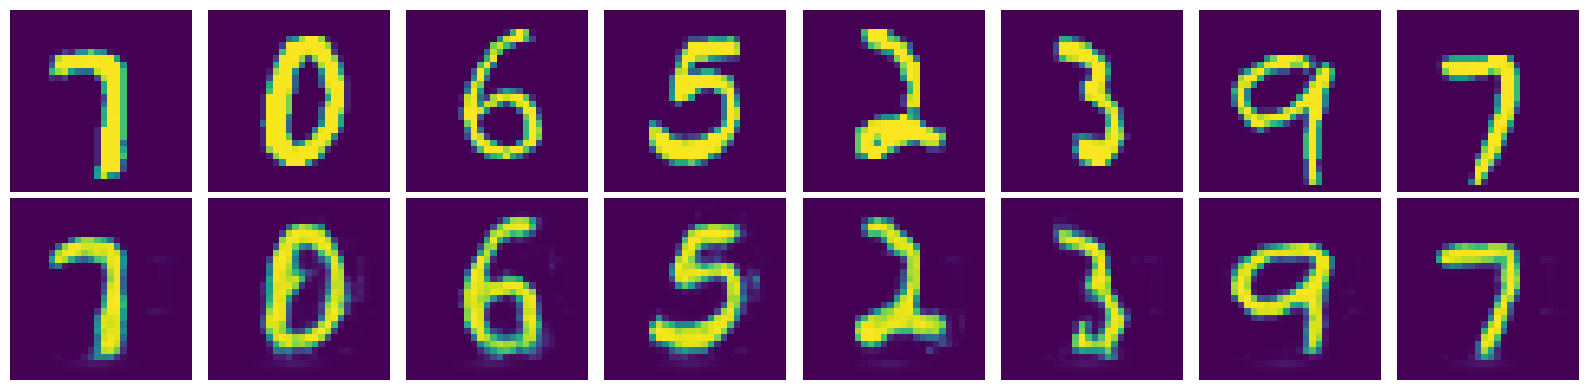

In [526]:
import torch
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import random

@torch.no_grad()
def show_reconstructions(model, dataset, device, n=8):
    model.eval()

    idx = random.sample(range(len(dataset)), n)
    x = torch.stack([dataset[i][0] for i in idx]).to(device)  # [B,28,28]
    #x = x / (x.norm(dim=(-1, -2), keepdim=True) + 1e-16)
    
    recon = torch.sigmoid(model.decode(andn_net(x)[0]))
    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))
    for i in range(n):
        axes[0, i].imshow(to_pil_image(x[i].cpu()))
        axes[0, i].axis("off")
        axes[1, i].imshow(to_pil_image(recon[i].cpu()))
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Reconstruction")
    plt.tight_layout()
    plt.show()

show_reconstructions(andn_net, mnist_test_dataset, device, n=8)

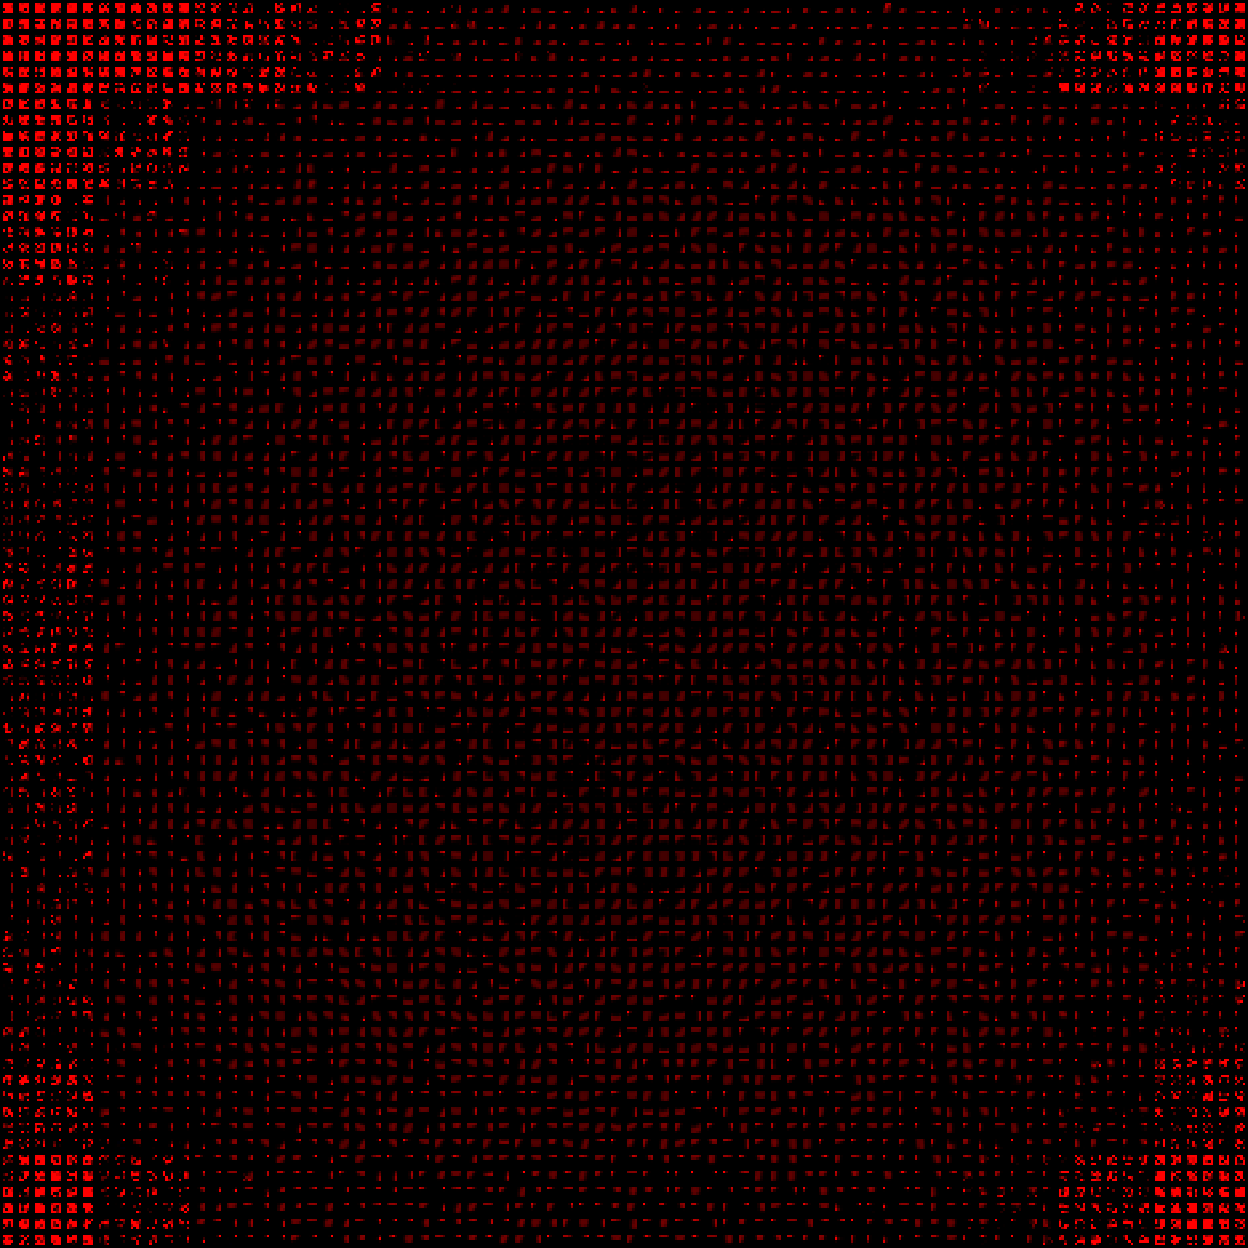

In [464]:
from spiky.util.visual_helpers import grayscale_to_red_and_blue
rf_d = p_dim
output_shape = andn_net.straight_layers[0].output_shape()
patch_h, patch_w = (rf_d, rf_d)
target_image = torch.zeros([output_shape[0] * (rf_d + 2), output_shape[1] * (rf_d + 2)])
weights = andn_net.straight_layers[0].export_weights()

for i in range(output_shape[0]):
    for j in range(output_shape[1]):
        target_image[
            i * (rf_d + 2) + 1:i * (rf_d+ 2) + rf_d + 1,
            j * (rf_d + 2) + 1:j * (rf_d + 2) + rf_d + 1
        ] = weights[i, j]

img = grayscale_to_red_and_blue(target_image.unsqueeze(0))
color_rescaler = 1.0 / (img.abs().max() + 0.0000000001)
img = to_pil_image((img * color_rescaler).clip(0.0, 1.0))
img.resize(
    [
        output_shape[0] * rf_d * 4, 
        output_shape[1] * rf_d * 4
    ], Image.NEAREST
)

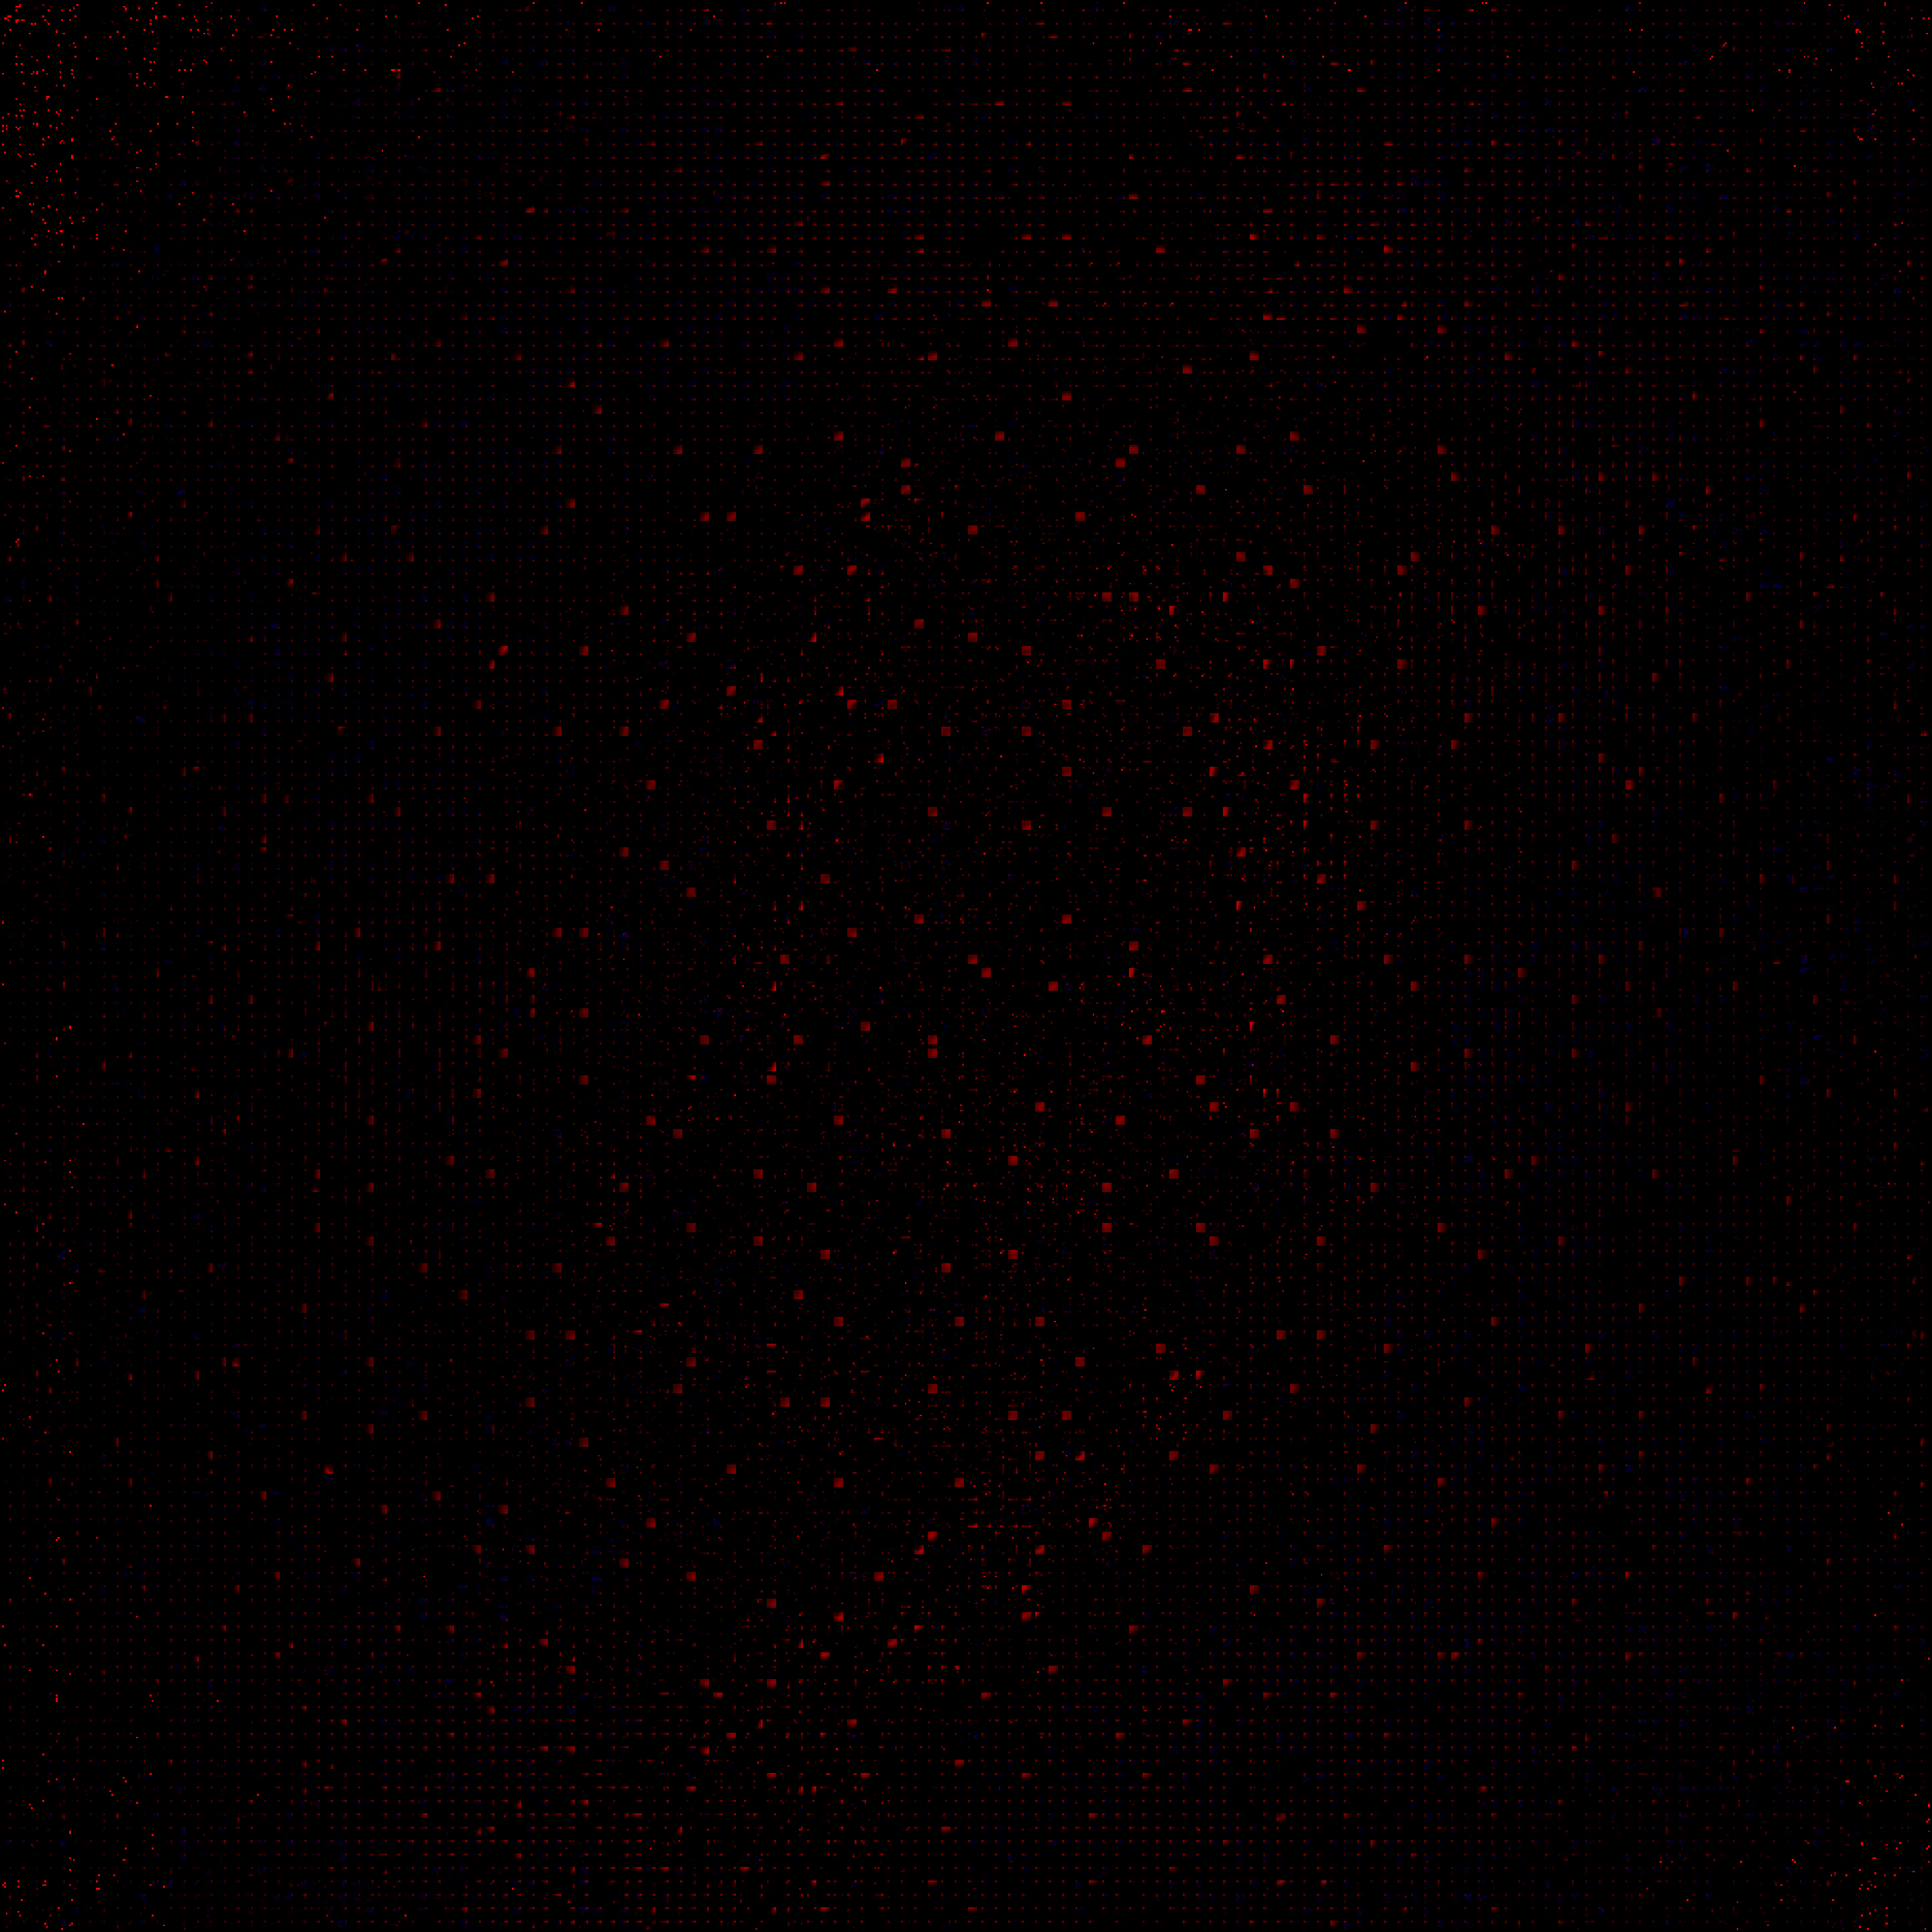

In [153]:
from spiky.util.visual_helpers import grayscale_to_red_and_blue

rf_d = p_dim
output_shape = andn_net.straight_layers[0].output_shape()
patch_h, patch_w = (rf_d, rf_d)
target_image = torch.zeros([output_shape[0] * (rf_d + 2), output_shape[1] * (rf_d + 2)])
weights = andn_net.straight_layers[0].export_weights()

for i in range(output_shape[0]):
    for j in range(output_shape[1]):
        target_image[
            i * (rf_d + 2) + 1:i * (rf_d+ 2) + rf_d + 1,
            j * (rf_d + 2) + 1:j * (rf_d + 2) + rf_d + 1
        ] = weights[i, j]

img = grayscale_to_red_and_blue(target_image.unsqueeze(0))
color_rescaler = 1.0 / (img.abs().max() + 0.0000000001)
img = to_pil_image((img * color_rescaler * 8).clip(0.0, 1.0))
img.resize(
    [
        output_shape[0] * rf_d * 4, 
        output_shape[1] * rf_d * 4
    ], Image.NEAREST
)

In [493]:
andn_net.straight_layers[0]._backprop_hebb_ratio_on_torch_backward = 0.0
andn_net.straight_layers[1]._backprop_hebb_ratio_on_torch_backward = 0.0

# Layered ANDN network

In [ ]:
from spiky.andn.ANDNLayer import Conv2DANDNLayer, SynapseMeta

input_shape=(28, 28)
final_output_shape = (1, 10)
cl_d = 6
rf_d = 5
synapse_meta_1 = SynapseMeta(
    min_weight=0.0,
    max_weight=10.0,
    initial_weight=1.0,
    initial_noise_level=-10.0
)

synapse_meta_2 = SynapseMeta(
    learning_rate=0.1,
    min_weight=-1.0,
    max_weight=1.0,
    initial_weight=1.0,
    initial_noise_level=-2.0
)

class ANDNNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.layer1 = Conv2DANDNLayer(
            input_shape=input_shape,
            inhibition_grid_shape=None,
            receptive_field_shape=(rf_d, rf_d),
            receptive_field_stride_shape=(1, 1),
            output_kernel_shape=(cl_d, cl_d),
            backprop_hebb_ratio_on_torch_backward=1.0,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer2 = Conv2DANDNLayer(
            input_shape=self.layer1.output_shape(),
            inhibition_grid_shape=(cl_d, cl_d),
            receptive_field_shape=(rf_d * cl_d, rf_d * cl_d),
            receptive_field_stride_shape=(cl_d, cl_d),
            output_kernel_shape=(cl_d, cl_d),
            backprop_hebb_ratio_on_torch_backward=1.0,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer1.set_descendant_andn_layer(self.layer2)
        self.layer3 = Conv2DANDNLayer(
            input_shape=self.layer2.output_shape(),
            inhibition_grid_shape=(cl_d, cl_d),
            receptive_field_shape=(rf_d * cl_d, rf_d * cl_d),
            receptive_field_stride_shape=(cl_d, cl_d),
            output_kernel_shape=(cl_d, cl_d),
            backprop_hebb_ratio_on_torch_backward=1.0,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer2.set_descendant_andn_layer(self.layer3)
        self.layer4 = Conv2DANDNLayer(
            input_shape=self.layer3.output_shape(),
            inhibition_grid_shape=(cl_d, cl_d),
            receptive_field_shape=self.layer3.output_shape(),
            receptive_field_stride_shape=self.layer2.output_shape(),
            output_kernel_shape=final_output_shape,
            backprop_hebb_ratio_on_torch_backward=0.0,
            synapse_meta=synapse_meta_2,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer3.set_descendant_andn_layer(self.layer4)

    def forward(self, x):
        # x = x / (x.norm(dim=(-1, -2), keepdim=True) + 1e-16)
        return self.layer4(self.layer3(self.layer2(self.layer1(x)))).squeeze(1)

In [ ]:
layered_andn_net = ANDNNet(device)
layered_andn_net

In [ ]:
total = sum(p.numel() for p in layered_andn_net.parameters())
trainable = sum(p.numel() for p in layered_andn_net.parameters() if p.requires_grad)

print("total:", total)
print("trainable:", trainable)
print("frozen:", total - trainable)

In [ ]:
optimizer = optim.Adam(layered_andn_net.parameters(), lr=0.01)

loss_func = nn.CrossEntropyLoss()
for epoch in range(16):
    layered_andn_net.train()
    train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=128, shuffle=True)
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=10)
        optimizer.zero_grad()
        output = layered_andn_net(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(train_loader.dataset)
    
    layered_andn_net.eval()
    correct = 0
    with torch.no_grad():
        test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=256, shuffle=True)
        for data, target in test_loader:
            output = layered_andn_net(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    print(f'Epoch {epoch+1} Train/test accuracy: {train_acc:.2f}/{test_acc:.2f}')

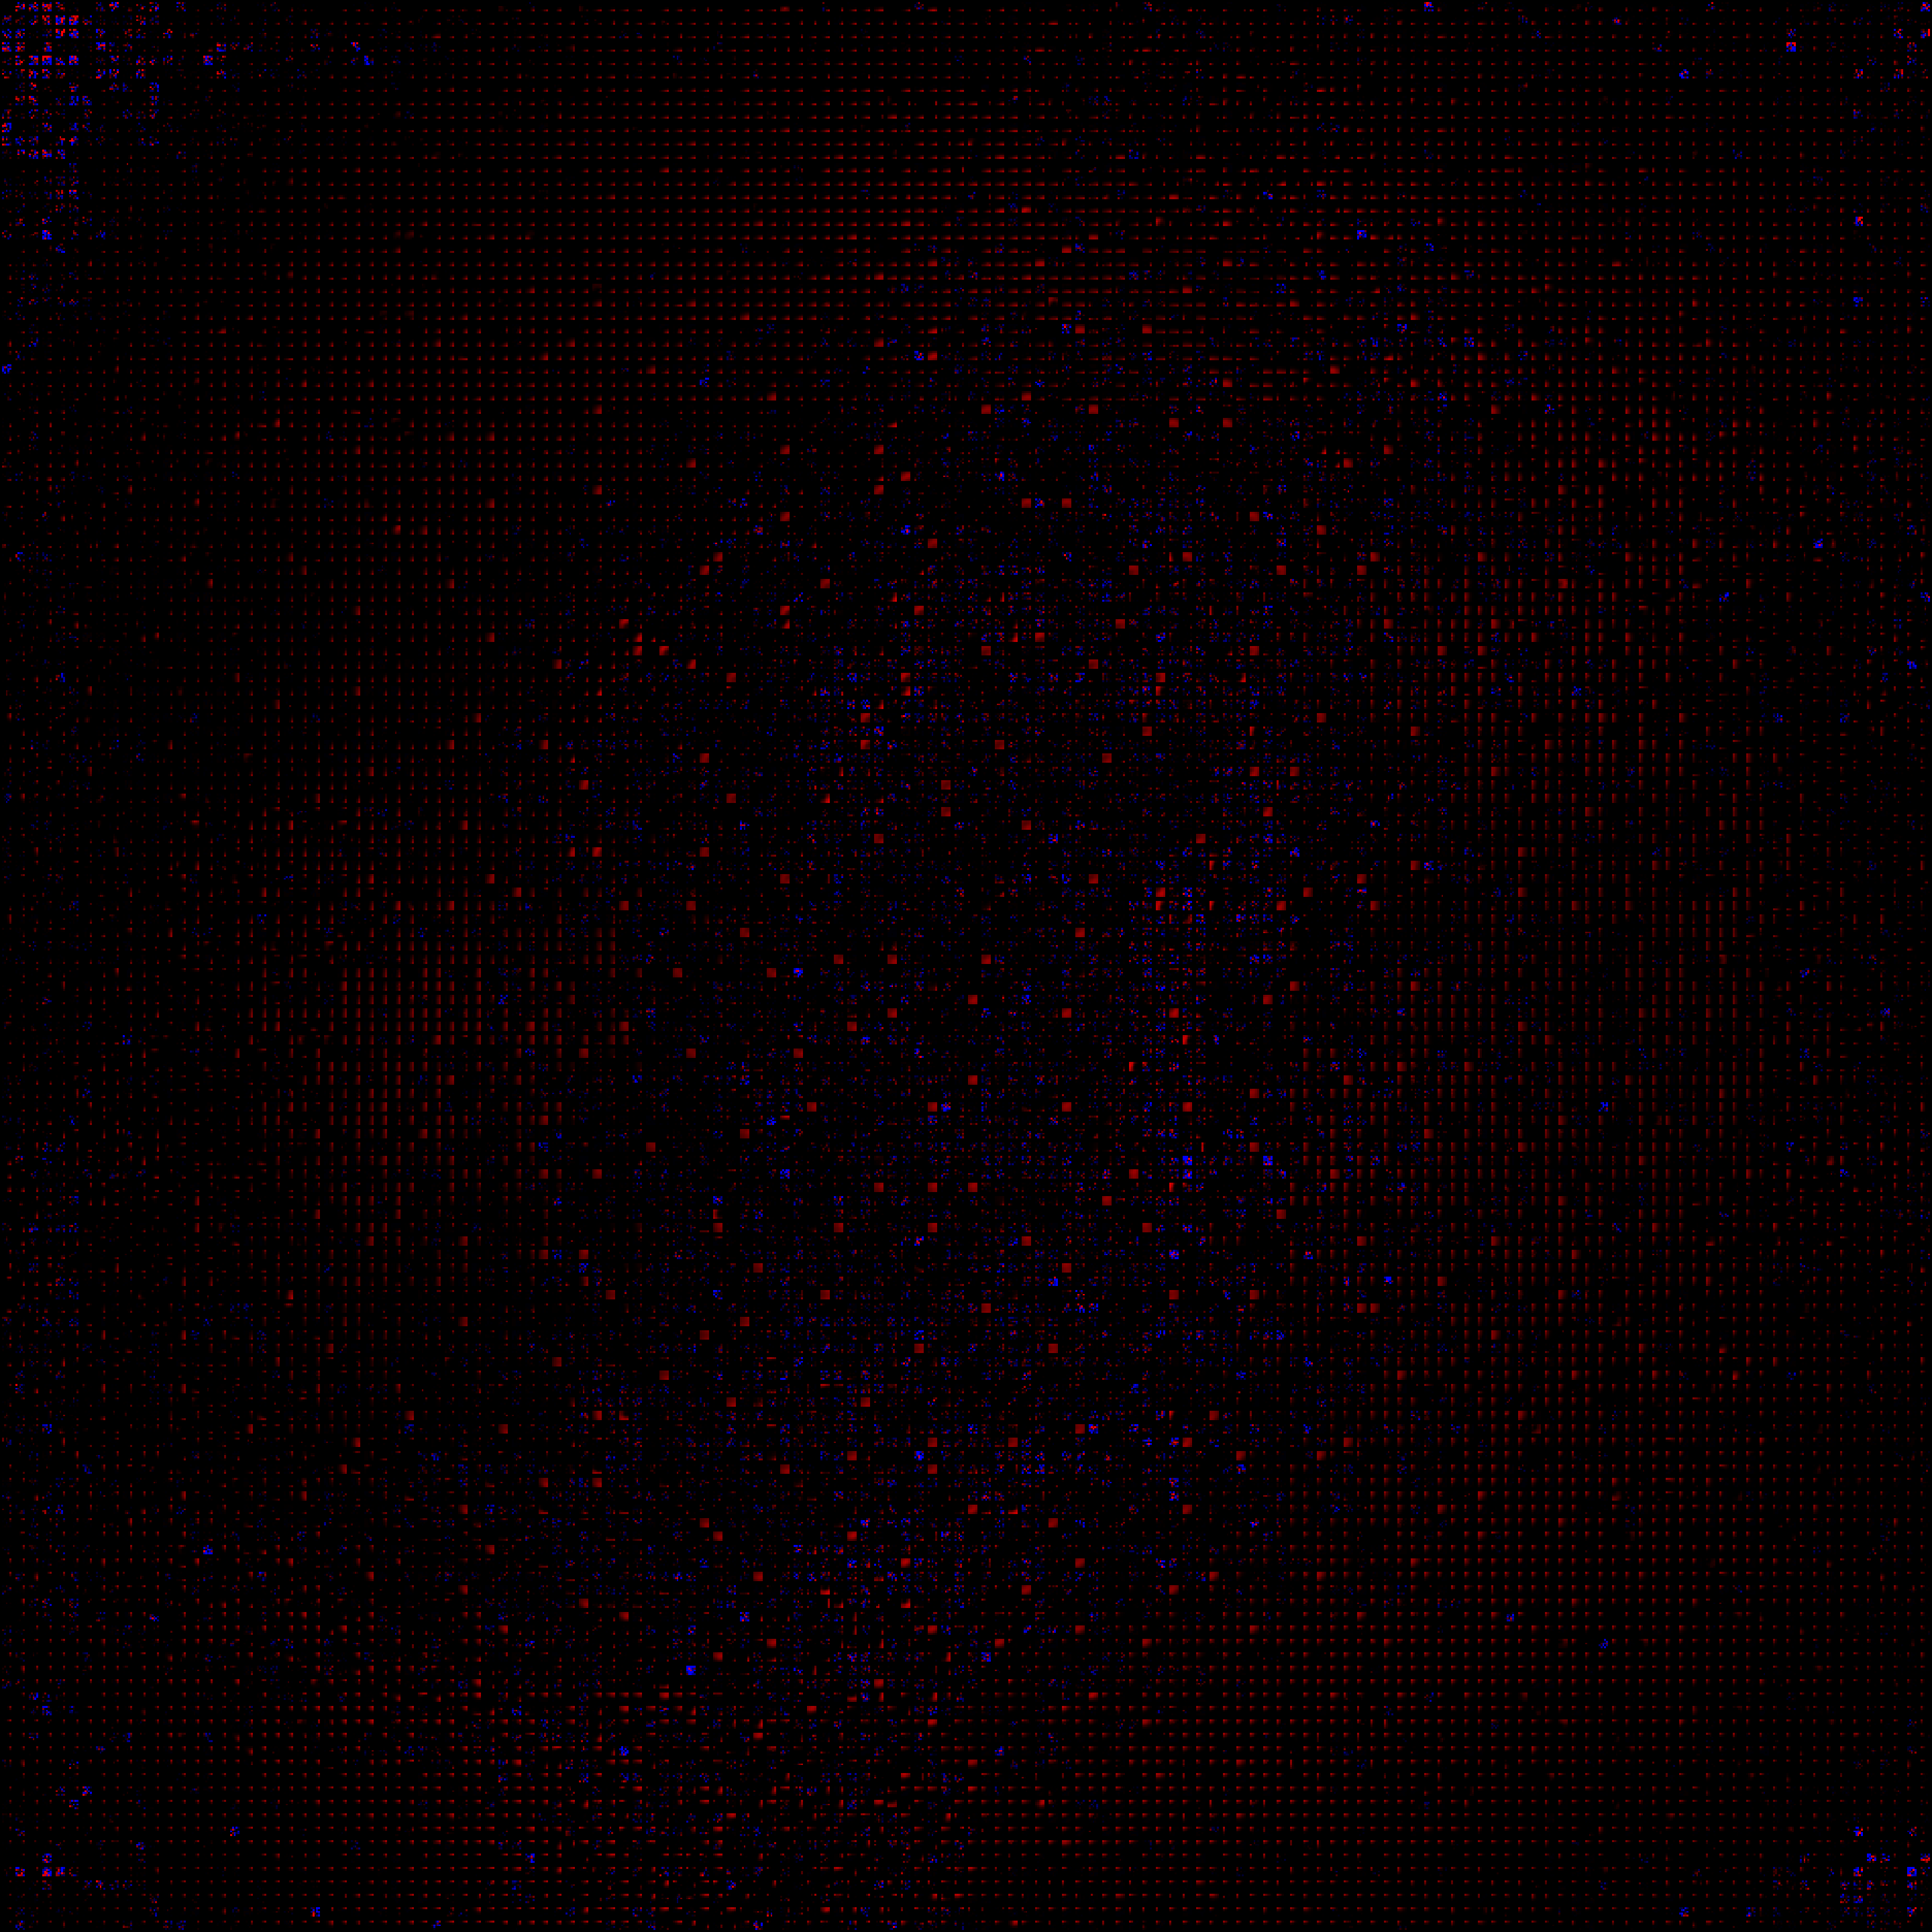

In [179]:
from spiky.util.visual_helpers import grayscale_to_red_and_blue

output_shape = andn_net.straight_layers[0].output_shape()
patch_h, patch_w = (p_dim, p_dim)
target_image = torch.zeros([output_shape[0] * (p_dim + 2), output_shape[1] * (p_dim + 2)])
weights = andn_net.straight_layers[0].export_weights()

for i in range(output_shape[0]):
    for j in range(output_shape[1]):
        target_image[
            i * (p_dim + 2) + 1:i * (p_dim+ 2) + p_dim + 1,
            j * (p_dim + 2) + 1:j * (p_dim + 2) + p_dim + 1
        ] = weights[i, j]

img = grayscale_to_red_and_blue(target_image.unsqueeze(0))
color_rescaler = 1.0 / (img.abs().max() + 0.0000000001)
img = to_pil_image((img * color_rescaler).clip(0.0, 1.0))
img.resize(
    [
        output_shape[0] * p_dim * 4, 
        output_shape[1] * p_dim * 4
    ], Image.NEAREST
)

In [ ]:
import torch

B, N, M = 4, 10, 6

# make independent random noise per batch and sort to get unique order
noise = torch.rand(B, N * (N - 1), device=device)
idx = noise.argsort(dim=1)[:, :M]  # each row = independent permutation

# decode to ordered pairs
i = idx // (N - 1)
j = idx % (N - 1)
j[j >= i] += 1

pairs = torch.stack((i, j), dim=-1)  # [B, M, 2]

In [ ]:
noise.argsort(dim=1).shape

In [ ]:
x = 7
x & (x - 1)

In [ ]:
64 * 25 * 24 * 24

In [ ]:
784 * 2304

In [ ]:
24 * 24 * 64

In [ ]:
from spiky.andn.ANDNLayer import Conv2DANDNLayer, SynapseMeta

synapse_meta_1 = SynapseMeta(
    min_weight=0.0,
    max_weight=10.0,
    initial_weight=1.0,
    initial_noise_level=-10.0
)

synapse_meta_2 = SynapseMeta(
    min_weight=-1.0,
    max_weight=1.0,
    initial_weight=1.0,
    initial_noise_level=-2.0
)

class ANDNNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.layer1 = Conv2DANDNLayer(
            input_shape=input_shape,
            inhibition_grid_shape=None,
            receptive_field_shape=(5, 5),
            receptive_field_stride_shape=(1, 1),
            output_kernel_shape=(6, 6),
            backprop_hebb_ratio_on_torch_backward=1.0,
            #anti_hebb_coeff=0.4,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer2 = Conv2DANDNLayer(
            input_shape=self.layer1.output_shape(),
            inhibition_grid_shape=(6, 6),
            receptive_field_shape=(5 * 6, 5 * 6),
            receptive_field_stride_shape=(6, 6),
            output_kernel_shape=(6, 6),
            backprop_hebb_ratio_on_torch_backward=1.0,
            #anti_hebb_coeff=0.4,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer3 = Conv2DANDNLayer(
            input_shape=self.layer2.output_shape(),
            inhibition_grid_shape=(6, 6),
            receptive_field_shape=(5 * 6, 5 * 6),
            receptive_field_stride_shape=(6, 6),
            output_kernel_shape=(6, 6),
            backprop_hebb_ratio_on_torch_backward=1.0,
            #anti_hebb_coeff=0.4,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer4 = Conv2DANDNLayer(
            input_shape=self.layer3.output_shape(),
            inhibition_grid_shape=output_kernel_shape,
            receptive_field_shape=self.layer1.output_shape(),
            receptive_field_stride_shape=self.layer1.output_shape(),
            output_kernel_shape=final_output_shape,
            backprop_hebb_ratio_on_torch_backward=0.0,
            synapse_meta=synapse_meta_2,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer1.set_descendant_andn_layer(self.layer2)

    def forward(self, x):
        # x = x / (x.norm(dim=(-1, -2), keepdim=True) + 1e-16)
        return self.layer2(self.layer1(x)).squeeze(1)

In [ ]:
from spiky.andn.ANDNLayer import Conv2DANDNLayer

straight_layer = Conv2DANDNLayer(
    input_shape=(144, 144,),
    inhibition_grid_shape=None,
    receptive_field_shape=(30, 30),
    receptive_field_stride_shape=(6, 6),
    output_kernel_shape=(6, 6),
    backprop_hebb_ratio_on_torch_backward=0.0,
    summation_dtype=summation_dtype,
    random_seed=random_seed,
    device=device
)

In [ ]:
straight_layer


In [ ]:
n_synapses = straight_layer._count_synapses(straight_layer.get_input_neuron_ids(), True)
synapses_export = {
    'source_ids': torch.zeros([n_synapses], dtype=torch.int32, device=device),
    'weights': torch.zeros([n_synapses], dtype=torch.float32, device=device),
    'target_ids': torch.zeros([n_synapses], dtype=torch.int32, device=device)
}

straight_layer._export_synapses(
    straight_layer.get_input_neuron_ids(),
    synapses_export['source_ids'],
    synapses_export['weights'],
    synapses_export['target_ids'],
    forward_or_backward=True
)

In [ ]:
synapses_export

In [ ]:
synapses_export['target_ids'].max()

In [ ]:
input_shape = (120, 120)
output_shape = (144, 144)

In [ ]:
n_outputs = output_shape[0] * output_shape[1]
n_outputs

In [ ]:
n_inputs = input_shape[0] * input_shape[1]
n_inputs

In [ ]:
explicit_triples = torch.cat(
    [
        torch.zeros([n_synapses, 1], dtype=torch.int32, device=device),
        synapses_export['target_ids'].unsqueeze(1) - n_outputs + 1,
        synapses_export['source_ids'].unsqueeze(1) + n_inputs + 1
    ],
    dim=-1
)

In [ ]:
print(explicit_triples)
print(explicit_triples.shape)
print(explicit_triples.min())
print(explicit_triples.max())

In [ ]:
explicit_triples[:,2].max()

In [ ]:
growth_engine = SynapseGrowthEngine(device=device, synapse_group_size=64, max_groups_in_buffer=2**20)
# growth_engine.register_neuron_type(
#     max_synapses=0|
#     growth_command_list=[]
# )
# growth_engine.register_neuron_type(
#     max_synapses=0,
#     growth_command_list=[]
# )

In [ ]:
chunk_of_connections=growth_engine._grow_explicit(explicit_triples, random_seed=51, do_sort_by_target_id=True)